# Feature selection para predicción del viento

Se importan las librerías.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Activation
from tensorflow import keras
import tensorflow as tf

Se importan los datos de entrenamiento y prueba.

In [39]:
df = pd.read_csv('./drive/MyDrive/DatosInvestigacion/final_train_2015.csv', index_col=0, parse_dates=True)
df = df.asfreq('h')
df = df[['SRGLOAVG1H','TAMAX1H','TAMIN1H','RHMAX1H','RHMIN1H','PRSUM1H','PAAVG1H','PAMAX1H','PAMIN1H','WS1HA','WS1HX','WD1HA']]
df_test = pd.read_csv('./drive/MyDrive/DatosInvestigacion/final_test_2015.csv', index_col=0, parse_dates=True)
df_test = df_test.asfreq('h')
df_test = df_test[['SRGLOAVG1H','TAMAX1H','TAMIN1H','RHMAX1H','RHMIN1H','PRSUM1H','PAAVG1H','PAMAX1H','PAMIN1H','WS1HA','WS1HX','WD1HA']]

Se establece el conjunto sobre el que se hará Feature Selection. Son las variables que no involucran la velocidad del viento.

In [40]:
x_train = df.drop(columns=['WS1HA','WS1HX'])

In [41]:
x_train.head()

,SRGLOAVG1H,TAMAX1H,TAMIN1H,RHMAX1H,RHMIN1H,PRSUM1H,PAAVG1H,PAMAX1H,PAMIN1H,WD1HA
Local_Time,,,,,,,,,,
2015-01-01 01:00:00,0.0,9.7,8.1,99.0,94.0,0.0,743.2,743.6,742.8,65
2015-01-01 02:00:00,0.0,9.8,9.1,97.0,94.0,0.0,742.6,742.8,742.4,43
2015-01-01 03:00:00,0.0,10.1,9.7,95.0,93.0,0.0,742.1,742.4,741.9,47
2015-01-01 04:00:00,0.0,10.3,9.7,96.0,93.0,0.0,741.8,741.9,741.7,44
2015-01-01 05:00:00,0.0,10.0,9.0,98.0,94.0,0.0,741.8,741.9,741.7,50


Se establece la velocidad del viento promedio como la variable que se quiere predecir.

In [42]:
y_train = df['WS1HA'].values

In [43]:
y_train[:5]

array([1. , 1.8, 1.9, 1.5, 1.4])

## Random Forest

Se importan las librerías para Random Forest.

In [44]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV

Se crea un objeto Random Forest para regresión.

In [45]:
rf = RandomForestRegressor()

Se establecen los parámetros para una pequeña búsqueda de optimización.

In [46]:
# Number of trees in random forest
n_estimators = [100,200,300]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [20,50,70,100]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

Se optimizan los hiperparámetros para Random Forest.

In [47]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [20, 50, 70, 100],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, verbose=2)

Se obtiene el mejor modelo.

In [48]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 50,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 100}

In [49]:
best_random = rf_random.best_estimator_

Se obtiene el nombre de las variables

In [50]:
features = x_train.columns

Se grafica la importancia que le da el modelo de Random Forest a las variables. La importancia se basa en el error cuadrado medio, las barras representan qué tanto crece el error cuando la variable no es considerada.

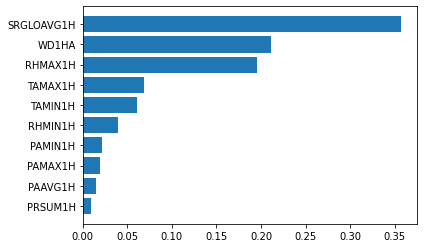

In [51]:
f_i = list(zip(features,best_random.feature_importances_))
f_i.sort(key = lambda x : x[1])
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])

plt.show()

Se utilizarán las tres variables más importantes que son: Radiación solar global, dirección del viento y humedad relativa máxima.